# Localized Homicide Clearance Rates, 1995-present


In [1]:
import os
import sqlite3
import pandas as pd


## Data Import

In [2]:
def should_chdir():
    """checks whether the code is being run interactively or from command line"""
    # if both these directories exist, treat is as the correct directory
    dirs = ["input", "output"]
    if all(os.path.exists(d) for d in dirs):
        return False

    try:
        shell = get_ipython().__class__.__name__  # type: ignore
        if shell == "ZMQInteractiveShell":
            return True
        elif shell == "TerminalInteractiveShell":
            return False
        else:
            return False
    except NameError:
        return False


# step backwards if notebook is being run interactively
# or stay put if being run from command line
if should_chdir():
    os.chdir("..")


In [3]:
with sqlite3.connect("input/sqlite__temp.db") as con:
    agencies = pd.read_sql("SELECT * FROM data_agencies;", con)
    gb_cols = "ori_code, agency_name, card, year"
    reta = pd.read_sql(
        f"""
        SELECT {gb_cols}, SUM(value) as total
        FROM data_reta
        GROUP BY {gb_cols};
    """,
        con,
    )


### Merging geographies

In [4]:
df = reta.merge(
    agencies,
    how="left",
    left_on=["ori_code", "year"],
    right_on=["ori", "data_year"],
)


### Filtering unwanted records

In [5]:
# FDLK24000 is for federal agencies, which all use the same ORI and won't be included here
df = df[df.ori_code != "FDLK24000"]


#### Selecting data only from agencies that regularly reported >1 clearance

This data contains zeros for both agencies that reported no data, and agencies that actually reported zero clearances. For example, the Chicago Police Department reported hundreds of homicides each year but no clearances at all

In [6]:
df[df.ori_code == "ILCPD0000"].pivot(index="year", columns="card", values="total")


card,actual,cleared_arrest
year,,
1995,824,0
1996,789,0
1997,757,0
1998,703,0
1999,642,0
2000,631,0
2001,666,0
2002,648,0
2003,598,0


To address this, I'm only going to look at agencies that reported at least 1 clearance to the FBI in at least ~90% of the years we're looking at; in this case, 23 out of the 26 years (~88.5%). This approach is adapted from [Jeremy Singer-Vine's excellent analysis](https://github.com/the-trace-and-buzzfeed-news/federal-crime-data-analysis/blob/master/notebooks/analyze/00-analyze-reta.ipynb) of this data in 2018 for Buzzfeed News. 

In [7]:
MIN_NONZERO_CLEARANCE_YEARS = 23
INCLUDE_AGENCIES_MERGE_COLS = ["ori_code", "agency_name"]

include_agencies = (
    pd.crosstab(
        index=[df.year, df.ori_code, df.agency_name],
        columns=df.card,
        values=df.total,
        aggfunc=sum,
    )
    .assign(nonzero_clearance=lambda df: df.cleared_arrest > 0)
    .reset_index()
    .groupby(INCLUDE_AGENCIES_MERGE_COLS)
    .nonzero_clearance.sum()
    .to_frame("nonzero_clearance_years")
    .query("nonzero_clearance_years > @MIN_NONZERO_CLEARANCE_YEARS")
)

include_agencies


,,nonzero_clearance_years
ori_code,agency_name,
AK0010100,ANCHORAGE,26
AL0020000,MOBILE,24
AL0110100,ANNISTON,26
AL0630000,TUSCALOOSA,24
AR0160100,JONESBORO,25
...,...,...
WI0130100,MADISON,24
WI0520200,RACINE,24
WIMPD0000,MILWAUKEE,26


Select only rows in the original dataframe that are in include_agencies

In [8]:
df = df.merge(
    include_agencies, how="right", left_on=INCLUDE_AGENCIES_MERGE_COLS, right_index=True
).drop("nonzero_clearance_years", axis=1)

df


,ori_code,agency_name,card,year,total,unique_id,data_year,ori,ncic_agency_name,state_abbr,county_name,msa_name,city_name
0,AK0010100,ANCHORAGE,actual,1995,29,00be478396bcfdd84f9361c6ed83ca28b167b0fd,1995.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
1,AK0010100,ANCHORAGE,actual,1996,25,ccc6735b0cb84b86330d20e09a4105a29542a540,1996.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
2,AK0010100,ANCHORAGE,actual,1997,23,ec895861f02e61281526c06303cffaf7f160c2df,1997.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
3,AK0010100,ANCHORAGE,actual,1998,19,16c8416a45081736b85ca65ab08f492bf65d8e33,1998.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
4,AK0010100,ANCHORAGE,actual,1999,19,4503dee76665fda72813b58373430cf6f3eca029,1999.0,AK0010100,ANCHORAGE PD,AK,ANCHORAGE,"Ames, IA",ANCHORAGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083395,WV0200200,CHARLESTON,cleared_arrest,2016,5,2ea033e3f0fe5025cc2d32cf1b8c7f101da3a859,2016.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON
1083396,WV0200200,CHARLESTON,cleared_arrest,2017,6,442ed5a00abbbaefa2eb14c8117ac0b0b9cf5e7f,2017.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON
1083397,WV0200200,CHARLESTON,cleared_arrest,2018,3,2c33fb670bcb80354d495a93da69f0825ba01e8a,2018.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON
1083398,WV0200200,CHARLESTON,cleared_arrest,2019,1,574cc587168ac2792f5ca6dba04aede3c69ec7d6,2019.0,WV0200200,CHARLESTON PD,WV,KANAWHA,"Charleston, WV",CHARLESTON


## Analysis

In [9]:
def get_clearance_rate(crosstab_df):
    for year in df.year.unique().tolist():
        crosstab_df[(year, "clearance_rate")] = (
            crosstab_df[(year, "cleared_arrest")] / crosstab_df[(year, "actual")]
        )
    crosstab_df = crosstab_df.sort_index(axis=1, level="year", sort_remaining=False)
    return crosstab_df


def get5yravg_vs_2020(clearance_rate_df):
    cr_5yravg = clearance_rate_df[
        [(yr, "clearance_rate") for yr in range(2015, 2021)]
    ].droplevel(1, axis=1)
    cr_5yravg["5_year_avg"] = cr_5yravg.iloc[:, :-1].mean(axis=1)
    cr_5yravg = cr_5yravg[["5_year_avg", 2020]]
    cr_5yravg["change"] = (cr_5yravg[2020] - cr_5yravg["5_year_avg"]) / cr_5yravg[
        "5_year_avg"
    ]
    return cr_5yravg


### National

Of these agencies we're looking at, overall, the clearance rate fell from a high of about 65% in the late 90s to about 52% in 2020.

In [20]:
national = pd.crosstab(
    index=df.year,
    columns=df.card,
    values=df.total,
    aggfunc=sum,
).assign(clearance_rate=lambda df: df.cleared_arrest / df.actual)

national


card,actual,cleared_arrest,clearance_rate
year,,,
1995,10580,6387,0.603686
1996,9535,5789,0.607132
1997,8796,5461,0.620850
1998,7927,5134,0.647660
1999,7134,4596,0.644239
2000,7568,4464,0.589852
2001,7920,4585,0.578914
2002,8225,4886,0.594043
2003,8347,5024,0.601893


<AxesSubplot:xlabel='year'>

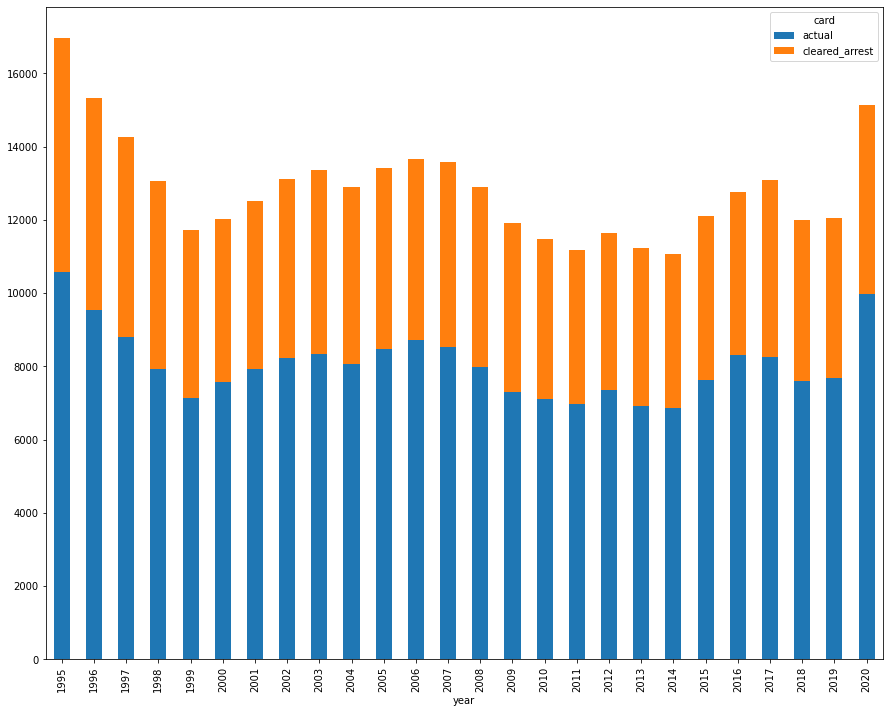

In [33]:
national[["actual", "cleared_arrest"]].plot(kind="bar", stacked=True, figsize=(15, 12))


In [34]:
national.to_csv("output/national.csv")


### By state

In [45]:
state = (
    pd.crosstab(
        index=[df.year, df.state_abbr],
        columns=df.card,
        values=df.total,
        aggfunc=sum,
    )
    .assign(clearance_rate=lambda df: df.cleared_arrest / df.actual)
    .reset_index()
    .set_index("state_abbr")
)

state.columns.name = None

state


,year,actual,cleared_arrest,clearance_rate
state_abbr,,,,
AK,1995,29,19,0.655172
AL,1995,11,6,0.545455
AR,1995,115,75,0.652174
AZ,1995,387,216,0.558140
CA,1995,2352,1345,0.571854
...,...,...,...,...
UT,2020,23,13,0.565217
VA,2020,287,153,0.533101
WA,2020,147,80,0.544218


### By MSA

In [12]:
msa = get_clearance_rate(
    pd.crosstab(
        index=[df.msa_name],
        columns=[df.year, df.card],
        values=df.total,
        aggfunc=sum,
    )
)

msa


year                          1995                                 1996  \
card                        actual cleared_arrest clearance_rate actual   
msa_name                                                                  
Abilene, TX                    5.0            2.0       0.400000    7.0   
Albany, GA                    14.0           14.0       1.000000    1.0   
Albany-Schenectady-Troy, NY   15.0           10.0       0.666667   15.0   
Albuquerque, NM               53.0            9.0       0.169811   70.0   
Alexandria, LA                 7.0            7.0       1.000000    6.0   
...                            ...            ...            ...    ...   
Wichita Falls, TX              8.0            9.0       1.125000    9.0   
Wilmington, NC                 7.0            8.0       1.142857    4.0   
Winston-Salem, NC              NaN            NaN            NaN    NaN   
Worcester, MA-CT               5.0            2.0       0.400000    7.0   
Yakima, WA                    10.0            7.0       0.700000   13.0   

year                                                        1997  \
card                        cleared_arrest clearance_rate actual   
msa_name                                                           
Abilene, TX                            5.0       0.714286    2.0   
Albany, GA                             1.0       1.000000    8.0   
Albany-Schenectady-Troy, NY           13.0       0.866667    9.0   
Albuquerque, NM                       19.0       0.271429   49.0   
Alexandria, LA                         5.0       0.833333    7.0   
...                                    ...            ...    ...   
Wichita Falls, TX                     11.0       1.222222    1.0   
Wilmington, NC                         2.0       0.500000   12.0   
Winston-Salem, NC                      NaN            NaN    NaN   
Worcester, MA-CT                       3.0       0.428571    5.0   
Yakima, WA                             9.0       0.692308   11.0   

year                                                        1998  ...  \
card                        cleared_arrest clearance_rate actual  ...   
msa_name                                                          ...   
Abilene, TX                            2.0       1.000000    5.0  ...   
Albany, GA                             7.0       0.875000    9.0  ...   
Albany-Schenectady-Troy, NY            5.0       0.555556    7.0  ...   
Albuquerque, NM                       23.0       0.469388   37.0  ...   
Alexandria, LA                         5.0       0.714286    7.0  ...   
...                                    ...            ...    ...  ...   
Wichita Falls, TX                      0.0       0.000000    6.0  ...   
Wilmington, NC                        12.0       1.000000    9.0  ...   
Winston-Salem, NC                      NaN            NaN    NaN  ...   
Worcester, MA-CT                       3.0       0.600000    4.0  ...   
Yakima, WA                             7.0       0.636364    8.0  ...   

year                                  2017   2018                 \
card                        clearance_rate actual cleared_arrest   
msa_name                                                           
Abilene, TX                       0.750000    8.0            5.0   
Albany, GA                        0.954545   15.0           13.0   
Albany-Schenectady-Troy, NY       0.900000   13.0            9.0   
Albuquerque, NM                   0.514286   69.0           16.0   
Alexandria, LA                    0.705882   12.0            9.0   
...                                    ...    ...            ...   
Wichita Falls, TX                 1.250000    5.0            3.0   
Wilmington, NC                    1.055556    9.0            7.0   
Winston-Salem, NC                 0.416667   23.0           15.0   
Worcester, MA-CT                  0.600000    5.0            2.0   
Yakima, WA                        0.352941   21.0           13.0   

year                

In [13]:
msa_5yravg = get5yravg_vs_2020(msa)
msa_5yravg


year,5_year_avg,2020,change
msa_name,,,
"Abilene, TX",0.866667,1.000000,0.153846
"Albany, GA",0.889242,0.473684,-0.467317
"Albany-Schenectady-Troy, NY",0.753202,0.619048,-0.178112
"Albuquerque, NM",0.481177,0.175000,-0.636308
"Alexandria, LA",0.656544,0.263158,-0.599177
...,...,...,...
"Wichita Falls, TX",0.853333,0.666667,-0.218750
"Wilmington, NC",0.855238,0.636364,-0.255922
"Winston-Salem, NC",0.755254,1.000000,0.324059


### By agency

In [14]:
agency = get_clearance_rate(
    pd.crosstab(
        index=[df.ori_code, df.agency_name],
        columns=[df.year, df.card],
        values=df.total,
        aggfunc=sum,
    )
)
agency


year                    1995                                 1996  \
card                  actual cleared_arrest clearance_rate actual   
ori_code  agency_name                                               
AK0010100 ANCHORAGE     29.0           19.0       0.655172   25.0   
AL0020000 MOBILE         3.0            0.0       0.000000    7.0   
AL0110100 ANNISTON       6.0            4.0       0.666667   10.0   
AL0630000 TUSCALOOSA     2.0            2.0       1.000000    5.0   
AR0160100 JONESBORO      3.0            1.0       0.333333    4.0   
...                      ...            ...            ...    ...   
WI0130100 MADISON        5.0            4.0       0.800000    1.0   
WI0520200 RACINE        11.0            7.0       0.636364   12.0   
WIMPD0000 MILWAUKEE    138.0          114.0       0.826087  130.0   
WV0200000 KANAWHA        4.0            3.0       0.750000    4.0   
WV0200200 CHARLESTON     9.0            8.0       0.888889    7.0   

year                                                  1997                 \
card                  cleared_arrest clearance_rate actual cleared_arrest   
ori_code  agency_name                                                       
AK0010100 ANCHORAGE             16.0       0.640000   23.0           21.0   
AL0020000 MOBILE                 6.0       0.857143    4.0            5.0   
AL0110100 ANNISTON               9.0       0.900000    5.0            3.0   
AL0630000 TUSCALOOSA             0.0       0.000000    1.0            1.0   
AR0160100 JONESBORO              5.0       1.250000    4.0            4.0   
...                              ...            ...    ...            ...   
WI0130100 MADISON                2.0       2.000000    3.0            2.0   
WI0520200 RACINE                12.0       1.000000    9.0            5.0   
WIMPD0000 MILWAUKEE            106.0       0.815385  122.0          104.0   
WV0200000 KANAWHA                1.0       0.250000    2.0            2.0   
WV0200200 CHARLESTON             5.0       0.714286    5.0            2.0   

year                                   1998  ...           2017   2018  \
card                  clearance_rate actual  ... clearance_rate actual   
ori_code  agency_name                        ...                         
AK0010100 ANCHORAGE         0.913043   19.0  ...       1.037037   26.0   
AL0020000 MOBILE            1.250000    3.0  ...       1.000000    1.0   
AL0110100 ANNISTON          0.600000    9.0  ...       0.928571    7.0   
AL0630000 TUSCALOOSA        1.000000    3.0  ...       1.000000    3.0   
AR0160100 JONESBORO         1.000000    1.0  ...       1.076923    4.0   
...                              ...    ...  ...            ...    ...   
WI0130100 MADISON           0.666667    5.0  ...       0.750000    5.0   
WI0520200 RACINE            0.555556    0.0  ...       1.000000    8.0   
WIMPD0000 MILWAUKEE         0.852459  111.0  ...       0.689076   99.0   
WV0200000 KANAWHA           1.000000    6.0  ...       0.500000    7.0   
WV0200200 CHARLESTON        0.400000    8.0  ...       0.600000   10.0   

year                                                  2019                 \
card                  cleared_arrest clearance_rate actual cleared_arrest   
ori_code  agency_name                                                       
AK0010100 ANCHORAGE             14.0       0.538462   32.0           21.0   
AL0020000 MOBILE                 1.0       1.000000    3.0            3.0   
AL0110100 ANNISTON               5.0       0.714286    4.0            4.0   
AL0630000 TUSCALOOSA             3.0       1.000000    4.0            1.0   
AR0160100 JONESBORO              4.0       1.000000   13.0           13.0   
...                              ...            ...    ...            ...   
WI0130100 MADISON                3.0       0.600000    4.0            4.0   
WI0520200 RACINE                 2.0       0.250000    4.0            2.0   
WIMPD0000 MILWAUKEE             65.0       0.656566   97.0           6

In [15]:
agency_5yravg = get5yravg_vs_2020(agency)
agency_5yravg


,year,5_year_avg,2020,change
ori_code,agency_name,,,
AK0010100,ANCHORAGE,0.750745,0.833333,0.110008
AL0020000,MOBILE,0.933333,0.600000,-0.357143
AL0110100,ANNISTON,0.878571,0.833333,-0.051491
AL0630000,TUSCALOOSA,0.850000,0.500000,-0.411765
AR0160100,JONESBORO,0.835385,0.833333,-0.002455
...,...,...,...,...
WI0130100,MADISON,0.770000,0.700000,-0.090909
WI0520200,RACINE,0.750000,1.500000,1.000000
WIMPD0000,MILWAUKEE,0.635616,0.539267,-0.151584


### Selecting only "core" agencies

In [16]:
AGENCIES = [
    "CA0194200",
    "CA0380100",
    "CA0340400",
    "TXDPD0000",
    "TX2201200",
    "TXHPD0000",
    "FL0130600",
    "CODPD0000",
    "PAPEP0000",
    "PAPPD0000",
    "NY0303000",
    "MN0271100",
    "MI8234900",
    "MA0130100",
    "MDBPD0000",
]


In [17]:
agency_subset = agency[agency.index.get_level_values("ori_code").isin(AGENCIES)].copy()
agency_subset


year                      1995                                 1996  \
card                    actual cleared_arrest clearance_rate actual   
ori_code  agency_name                                                 
CA0194200 LOS ANGELES    849.0          482.0       0.567727  711.0   
CA0340400 SACRAMENTO      57.0           41.0       0.719298   43.0   
CA0380100 SAN FRANCISCO   99.0           25.0       0.252525   82.0   
CODPD0000 DENVER          81.0           63.0       0.777778   64.0   
FL0130600 MIAMI          110.0           40.0       0.363636  124.0   
MA0130100 BOSTON          96.0           46.0       0.479167   59.0   
MDBPD0000 BALTIMORE      325.0          149.0       0.458462  330.0   
MI8234900 DETROIT        475.0            0.0       0.000000  428.0   
PAPEP0000 PHILADELPHIA   432.0          283.0       0.655093  420.0   
PAPPD0000 PITTSBURGH      58.0           48.0       0.827586   47.0   
TX2201200 FORT WORTH     108.0           79.0       0.731481   68.0   
TXDPD0000 DALLAS         276.0          207.0       0.750000  217.0   
TXHPD0000 HOUSTON        316.0          209.0       0.661392  261.0   

year                                                    1997                 \
card                    cleared_arrest clearance_rate actual cleared_arrest   
ori_code  agency_name                                                         
CA0194200 LOS ANGELES            408.0       0.573840  576.0          341.0   
CA0340400 SACRAMENTO              46.0       1.069767   41.0           30.0   
CA0380100 SAN FRANCISCO           47.0       0.573171   59.0           46.0   
CODPD0000 DENVER                  40.0       0.625000   69.0           36.0   
FL0130600 MIAMI                    0.0       0.000000   98.0            0.0   
MA0130100 BOSTON                  37.0       0.627119   43.0           20.0   
MDBPD0000 BALTIMORE              205.0       0.621212  312.0          170.0   
MI8234900 DETROIT                251.0       0.586449  469.0          204.0   
PAPEP0000 PHILADELPHIA           291.0       0.692857  418.0          274.0   
PAPPD0000 PITTSBURGH              31.0       0.659574   50.0           35.0   
TX2201200 FORT WORTH              45.0       0.661765   74.0           16.0   
TXDPD0000 DALLAS                 154.0       0.709677  209.0          154.0   
TXHPD0000 HOUSTON                179.0       0.685824  254.0          166.0   

year                                     1998  ...           2017   2018  \
card                    clearance_rate actual  ... clearance_rate actual   
ori_code  agency_name                          ...                         
CA0194200 LOS ANGELES         0.592014  426.0  ...       0.740214  258.0   
CA0340400 SACRAMENTO          0.731707   31.0  ...       0.538462   36.0   
CA0380100 SAN FRANCISCO       0.779661   58.0  ...       0.482143   46.0   
CODPD0000 DENVER              0.521739   51.0  ...       0.684211   65.0   
FL0130600 MIAMI               0.000000   86.0  ...       0.403846   27.0   
MA0130100 BOSTON              0.465116   34.0  ...       0.438596   56.0   
MDBPD0000 BALTIMORE           0.544872  313.0  ...       0.517544  309.0   
MI8234900 DETROIT             0.434968  430.0  ...       0.518797  263.0   
PAPEP0000 PHILADELPHIA        0.655502  338.0  ...       0.443038  351.0   
PAPPD0000 PITTSBURGH          0.700000   36.0  ...       0.654545   57.0   
TX2201200 FORT WORTH          0.216216   64.0  ...       0.676056   54.0   
TXDPD0000 DALLAS              0.736842  252.0  ...       0.796407  155.0   
TXHPD0000 HOUSTON             0.653543  254.0  ...       0.513011  279.0   

year                                                    2019                 \
card                    cleared_arrest clearance_rate actual cleared_arrest   
ori_code  agency_name                                                         
CA0194200 LOS ANGELES            197.0       0.763566  258.0          197.0   
CA0340400 SACRAMENTO              21.0       0.583333   34.0     

In [18]:
agency_5yravg[agency_5yravg.index.get_level_values("ori_code").isin(AGENCIES)]


,year,5_year_avg,2020,change
ori_code,agency_name,,,
CA0194200,LOS ANGELES,0.736397,0.549858,-0.253314
CA0340400,SACRAMENTO,0.580750,0.714286,0.229936
CA0380100,SAN FRANCISCO,0.656727,0.750000,0.142028
CODPD0000,DENVER,0.692525,0.649485,-0.062151
FL0130600,MIAMI,0.600712,0.442623,-0.263170
MA0130100,BOSTON,0.494952,0.293103,-0.407814
MDBPD0000,BALTIMORE,0.387028,0.471572,0.218443
MI8234900,DETROIT,0.409912,0.423780,0.033834
PAPEP0000,PHILADELPHIA,0.515784,0.373134,-0.276569
